In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # Smaller model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2



Class distribution: [416. 120. 561.]
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 96s 707ms/step - accuracy: 0.3129 - loss: 8.2927 - val_accuracy: 0.1091 - val_loss: 7.7012 - learning_rate: 1.0000e-04
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - accuracy: 0.4029 - loss: 7.5758 - val_accuracy: 0.5136 - val_loss: 7.0425 - learning_rate: 1.0000e-04
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.3763 - loss: 6.9014 - val_accuracy: 0.5136 - val_loss: 6.4202 - learning_rate: 1.0000e-04
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.4140 - loss: 6.3606 - val_accuracy: 0.3773 - val_loss: 5.9451 - learning_rate: 1.0000e-04
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.4559 - loss: 5.8408 - val_accuracy: 0.3773 - val_loss: 5.5630 - learning_rate: 1.0000e-04
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.4416 - loss: 5.4249 - val_accuracy: 0.3773 - val_loss: 5.1406 - learning_rate: 1.0000e-04
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.48

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


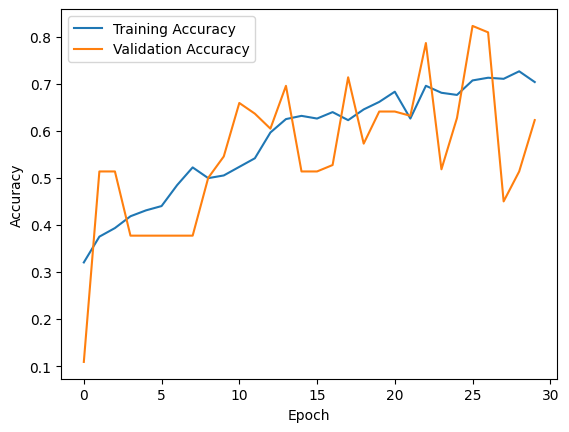

In [17]:
normal_path = r'/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Normal cases'
benign_path = r'/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases'
malignant_path = r'/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Malignant cases'


# Load images with color (remove grayscale conversion)
def load_images_and_labels(normal_path, benign_path, malignant_path):
    images = []
    labels = []
    
    # Load normal images
    for filename in os.listdir(normal_path):
        img = cv2.imread(os.path.join(normal_path, filename))
        img = cv2.resize(img, (256, 256))
        images.append(img)
        labels.append(0)
    
    # Load benign images
    for filename in os.listdir(benign_path):
        img = cv2.imread(os.path.join(benign_path, filename))
        img = cv2.resize(img, (256, 256))
        images.append(img)
        labels.append(1)
    
    # Load malignant images
    for filename in os.listdir(malignant_path):
        img = cv2.imread(os.path.join(malignant_path, filename))
        img = cv2.resize(img, (256, 256))
        images.append(img)
        labels.append(2)
    
    return np.array(images), np.array(labels)

# Load dataset
X, y = load_images_and_labels(normal_path, benign_path, malignant_path)
X = X / 255.0
y = tf.keras.utils.to_categorical(y, num_classes=3)

# Check class distribution
print("Class distribution:", np.sum(y, axis=0))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Calculate class weights for imbalanced data
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), 
                                      y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))

# Use smaller EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze some layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add custom layers with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Use lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Enhanced callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    CSVLogger('training_log.csv')
]

# Train with class weights
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))
print("Confusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


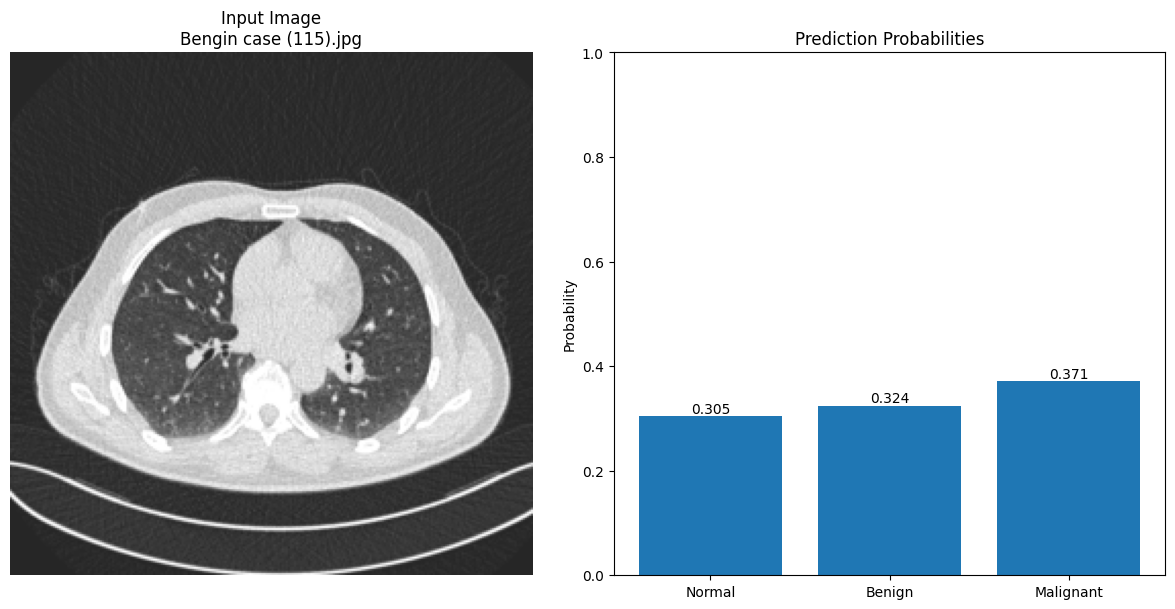


Prediction Results:
Predicted Class: Malignant
Confidence: 37.09%

Class Probabilities:
Normal: 30.46%
Benign: 32.45%
Malignant: 37.09%


In [28]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your trained model
model = load_model(r'Model\best_model.keras')  # Update with your model path

# Define class names
class_names = ['Normal', 'Benign', 'Malignant']

def predict_single_image(image_path):
    """
    Predicts lung cancer class for a single image
    Args:
        image_path: path to the image file
    Returns:
        Dictionary containing prediction results
    """
    # Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        return {"error": "Could not read the image"}
    
    # Preprocess (same as training)
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 255.0  # Convert to float32 before normalization
    
    # Add batch dimension and predict
    img_array = np.expand_dims(img, axis=0)
    predictions = model.predict(img_array)
    
    # Get results
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    class_scores = {class_names[i]: float(predictions[0][i]) for i in range(3)}
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Show original image (convert back to uint8 for display)
    plt.subplot(1, 2, 1)
    display_img = (img * 255).astype(np.uint8)  # Convert back to uint8 for display
    plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Input Image\n{image_path.split('/')[-1]}")
    plt.axis('off')
    
    # Show prediction probabilities
    plt.subplot(1, 2, 2)
    bars = plt.bar(class_names, predictions[0])
    plt.title('Prediction Probabilities')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    
    # Add confidence scores on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        "predicted_class": class_names[predicted_class],  # Fixed the key name
        "confidence": float(confidence),
        "class_probabilities": class_scores
    }

# Example usage
if __name__ == "__main__":
    # Replace with your image path
    image_path = r"archive\The IQ-OTHNCCD lung cancer dataset\Bengin cases\Bengin case (25).jpg"

    
    result = predict_single_image(image_path)
    
    # Check if there was an error first
    if "error" in result:
        print(f"Error: {result['error']}")
    else:
        print("\nPrediction Results:")
        print(f"Predicted Class: {result['predicted_class']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print("\nClass Probabilities:")
        for class_name, prob in result['class_probabilities'].items():
            print(f"{class_name}: {prob:.2%}")